# Análisis Avanzado con Máquinas de Vectores de Soporte (SVM)

---

## Objetivo del Análisis

Este notebook implementa un sistema completo de análisis y clasificación utilizando Máquinas de Vectores de Soporte (SVM) con múltiples configuraciones de kernel. El análisis incluye:

1. **Procesamiento y exploración** de conjuntos de datos
2. **Implementación de modelos SVM** con kernels variados (linear, poly, rbf, sigmoid)
3. **Búsqueda automática** de parámetros óptimos mediante GridSearchCV
4. **Representación gráfica** de fronteras de decisión
5. **Análisis exhaustivo** del rendimiento del modelo

**Autor:** Jesus Balbuena Palma 
**Fecha:** 25 Octubre 2025  

---

## 1. Importación de Librerías

Comenzamos importando todas las librerías necesarias para el análisis:

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Modelado y preprocesamiento
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['figure.figsize'] = (10, 6)
style.use('seaborn-v0_8') or plt.style.use('default')

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Carga y Exploración del Dataset

Importamos el conjunto de datos ESL.mixture desde el repositorio de GitHub:

In [2]:
# URL del dataset
data_url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/'
           'Estadistica-machine-learning-python/master/data/ESL.mixture.csv')

# Cargar datos
dataset = pd.read_csv(data_url)

print(f"Dataset cargado: {dataset.shape[0]} filas x {dataset.shape[1]} columnas")
print("\nPrimeras 5 observaciones:")
dataset.head()

Dataset cargado: 200 filas x 3 columnas

Primeras 5 observaciones:


,X1,X2,y
0,2.526093,0.321050,0
1,0.366954,0.031462,0
2,0.768219,0.717486,0
3,0.693436,0.777194,0
4,-0.019837,0.867254,0


### 2.1 Análisis Exploratorio de Datos (EDA)

In [3]:
print("="*60)
print("ANÁLISIS EXPLORATORIO DEL DATASET")
print("="*60)

print("\n1. Información general:")
print(dataset.info())

print("\n2. Estadísticas descriptivas:")
print(dataset.describe())

print("\n3. Distribución de clases:")
print(dataset['y'].value_counts())
print(f"\nProporción: {dataset['y'].value_counts(normalize=True)}")

print("\n4. Valores faltantes:")
print(dataset.isnull().sum())

ANÁLISIS EXPLORATORIO DEL DATASET

1. Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      200 non-null    float64
 1   X2      200 non-null    float64
 2   y       200 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 4.8 KB
None

2. Estadísticas descriptivas:
               X1          X2           y
count  200.000000  200.000000  200.000000
mean     0.784672    0.756016    0.500000
std      1.297582    1.026442    0.501255
min     -2.520820   -1.999853    0.000000
25%     -0.071465    0.095555    0.000000
50%      0.859702    0.861387    0.500000
75%      1.543438    1.435275    1.000000
max      4.170746    2.855805    1.000000

3. Distribución de clases:
y
0    100
1    100
Name: count, dtype: int64

Proporción: y
0    0.5
1    0.5
Name: proportion, dtype: float64

4. Valores faltantes:
X1    0
X2    0
y     0
d

### 2.2 Visualización del Dataset

Creamos un gráfico de dispersión para visualizar la distribución de las dos características y las clases:

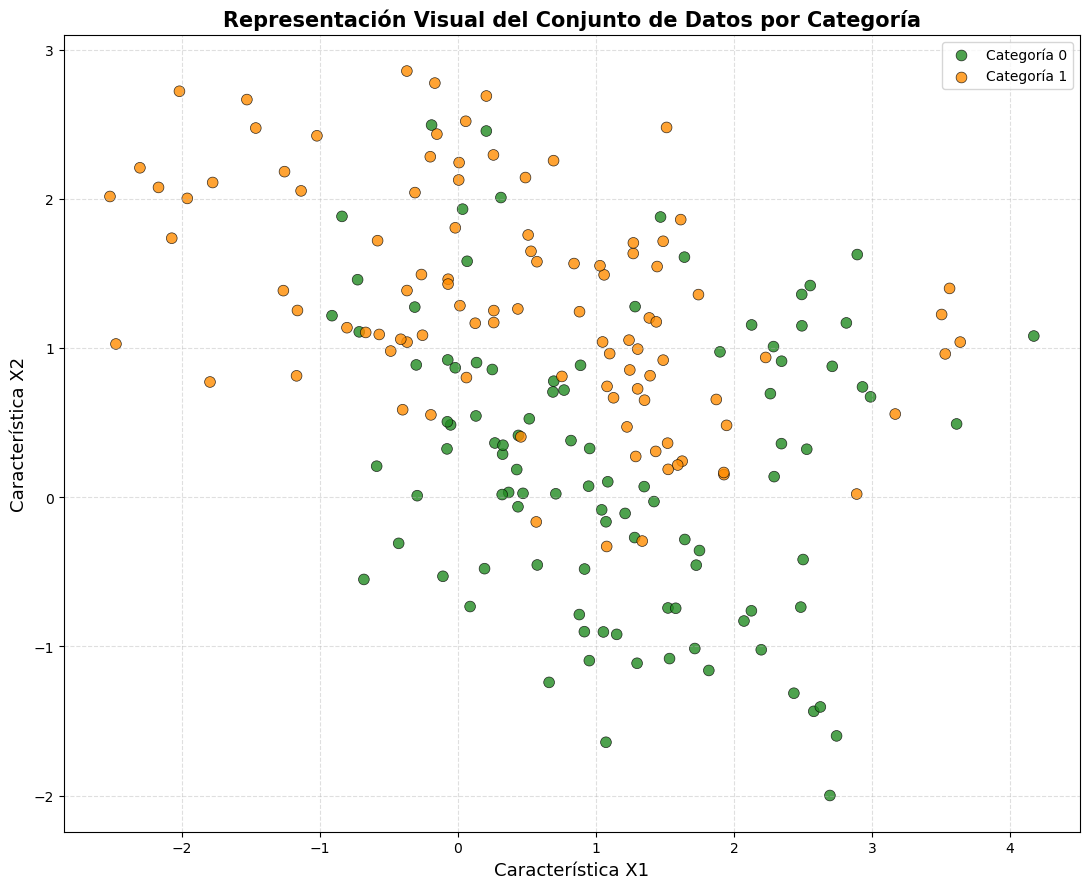

In [4]:
# Extraer características y target
X = dataset[['X1', 'X2']].values
y = dataset['y'].values

# Crear visualización
plt.figure(figsize=(11, 9))

color_map = ['forestgreen' if label == 0 else 'darkorange' for label in y]
plt.scatter(X[:, 0], X[:, 1], c=color_map, alpha=0.8, s=60, 
           edgecolors='black', linewidth=0.5)

plt.xlabel('Característica X1', fontsize=13)
plt.ylabel('Característica X2', fontsize=13)
plt.title('Representación Visual del Conjunto de Datos por Categoría', 
         fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.4, linestyle='--')

# Leyenda
plt.scatter([], [], c='forestgreen', alpha=0.8, s=60, 
           edgecolors='black', linewidth=0.5, label='Categoría 0')
plt.scatter([], [], c='darkorange', alpha=0.8, s=60, 
           edgecolors='black', linewidth=0.5, label='Categoría 1')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 3. Preparación de Datos

Dividimos el dataset en conjuntos de entrenamiento y prueba con estratificación:

In [5]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=123, 
    stratify=y
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} observaciones")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} observaciones")
print(f"\nDistribución en entrenamiento:")
print(pd.Series(y_train).value_counts())
print(f"\nDistribución en prueba:")
print(pd.Series(y_test).value_counts())

Tamaño del conjunto de entrenamiento: 160 observaciones
Tamaño del conjunto de prueba: 40 observaciones

Distribución en entrenamiento:
0    80
1    80
Name: count, dtype: int64

Distribución en prueba:
1    20
0    20
Name: count, dtype: int64


## 4. Construcción de Clasificadores SVM

### 4.1 Entrenamiento con Diferentes Kernels

Entrenamos clasificadores SVM con cuatro tipos de kernel diferentes:

In [6]:
print("="*60)
print("CONSTRUCCIÓN DE CLASIFICADORES SVM")
print("="*60)

# Diccionario para almacenar clasificadores
classifiers = {}
kernel_types = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel_type in kernel_types:
    print(f"\nEntrenando SVM con kernel {kernel_type}...")
    
    # Crear y entrenar clasificador
    clf = SVC(kernel=kernel_type, random_state=123)
    clf.fit(X_train, y_train)
    
    # Predicciones
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    # Métricas
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    # Almacenar resultados
    classifiers[kernel_type] = {
        'model': clf,
        'acc_train': acc_train,
        'acc_test': acc_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }
    
    print(f"  Precisión en entrenamiento: {acc_train:.4f}")
    print(f"  Precisión en prueba: {acc_test:.4f}")

print("\n✓ Clasificadores entrenados correctamente")

CONSTRUCCIÓN DE CLASIFICADORES SVM

Entrenando SVM con kernel linear...
  Precisión en entrenamiento: 0.7312
  Precisión en prueba: 0.7000

Entrenando SVM con kernel poly...
  Precisión en entrenamiento: 0.6750
  Precisión en prueba: 0.7000

Entrenando SVM con kernel rbf...
  Precisión en entrenamiento: 0.7937
  Precisión en prueba: 0.8250

Entrenando SVM con kernel sigmoid...
  Precisión en entrenamiento: 0.5687
  Precisión en prueba: 0.6000

✓ Clasificadores entrenados correctamente


### 4.2 Comparación de Rendimiento

Comparamos el rendimiento de todos los clasificadores:

In [7]:
# Crear DataFrame con resultados
results = []
for kernel, info in classifiers.items():
    results.append({
        'Kernel': kernel,
        'Precisión Entrenamiento': info['acc_train'],
        'Precisión Prueba': info['acc_test'],
        'Diferencia (Overfitting)': info['acc_train'] - info['acc_test']
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Precisión Prueba', ascending=False)

print("\nCOMPARACIÓN DE CLASIFICADORES:")
print("="*60)
print(results_df.to_string(index=False, float_format='%.4f'))


COMPARACIÓN DE CLASIFICADORES:
 Kernel  Precisión Entrenamiento  Precisión Prueba  Diferencia (Overfitting)
    rbf                   0.7937            0.8250                   -0.0312
 linear                   0.7312            0.7000                    0.0312
   poly                   0.6750            0.7000                   -0.0250
sigmoid                   0.5687            0.6000                   -0.0312


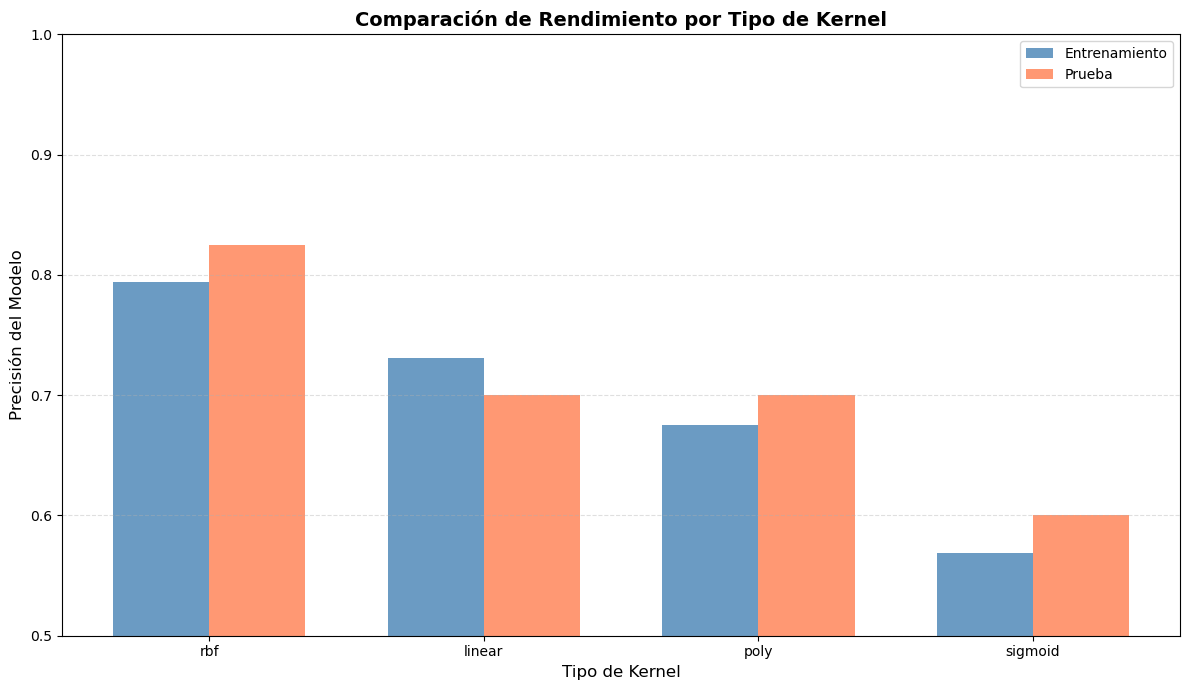

In [8]:
# Visualización comparativa
plt.figure(figsize=(12, 7))

x_pos = np.arange(len(results_df))
width = 0.35

plt.bar(x_pos - width/2, results_df['Precisión Entrenamiento'], 
       width, label='Entrenamiento', alpha=0.8, color='steelblue')
plt.bar(x_pos + width/2, results_df['Precisión Prueba'], 
       width, label='Prueba', alpha=0.8, color='coral')

plt.xlabel('Tipo de Kernel', fontsize=12)
plt.ylabel('Precisión del Modelo', fontsize=12)
plt.title('Comparación de Rendimiento por Tipo de Kernel', 
         fontsize=14, fontweight='bold')
plt.xticks(x_pos, results_df['Kernel'])
plt.legend()
plt.grid(True, alpha=0.4, linestyle='--', axis='y')
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

## 5. Optimización de Hiperparámetros

### 5.1 GridSearchCV para Kernel RBF

Optimizamos los hiperparámetros del kernel RBF (el más común) usando GridSearchCV:

In [9]:
print("="*60)
print("OPTIMIZACIÓN DE HIPERPARÁMETROS - KERNEL RBF")
print("="*60)

# Espacio de búsqueda
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1]
}

# GridSearchCV
grid_search = GridSearchCV(
    SVC(kernel='rbf', random_state=123),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nEjecutando búsqueda de hiperparámetros...")
grid_search.fit(X_train, y_train)

print(f"\n✓ Búsqueda completada")
print(f"\nMejores parámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nPuntuación en validación cruzada: {grid_search.best_score_:.4f}")

OPTIMIZACIÓN DE HIPERPARÁMETROS - KERNEL RBF

Ejecutando búsqueda de hiperparámetros...
Fitting 5 folds for each of 35 candidates, totalling 175 fits

✓ Búsqueda completada

Mejores parámetros encontrados:
  C: 10
  gamma: auto

Puntuación en validación cruzada: 0.7750


### 5.2 Evaluación del Modelo Optimizado

In [10]:
# Obtener mejor modelo
optimal_model = grid_search.best_estimator_

# Predicciones
y_pred_optimal = optimal_model.predict(X_test)

# Evaluación
acc_optimal = accuracy_score(y_test, y_pred_optimal)

print("="*60)
print("EVALUACIÓN DEL MODELO OPTIMIZADO")
print("="*60)
print(f"\nPrecisión en conjunto de prueba: {acc_optimal:.4f}")
print(f"\nReporte de clasificación:")
print(classification_report(y_test, y_pred_optimal, 
                          target_names=['Categoría 0', 'Categoría 1']))

EVALUACIÓN DEL MODELO OPTIMIZADO

Precisión en conjunto de prueba: 0.8500

Reporte de clasificación:
              precision    recall  f1-score   support

 Categoría 0       0.94      0.75      0.83        20
 Categoría 1       0.79      0.95      0.86        20

    accuracy                           0.85        40
   macro avg       0.86      0.85      0.85        40
weighted avg       0.86      0.85      0.85        40



### 5.3 Matriz de Confusión

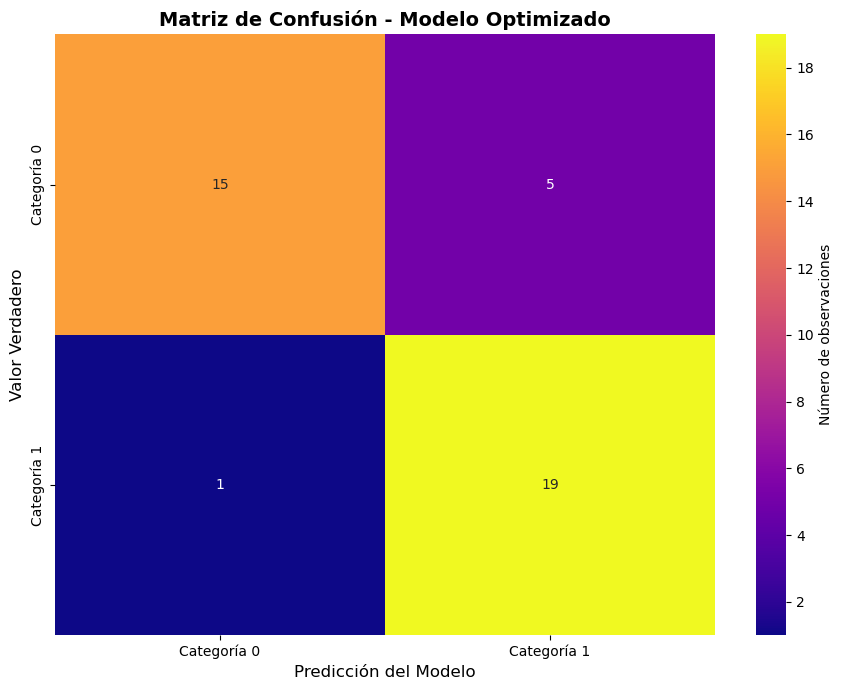


Matriz de Confusión:
[[15  5]
 [ 1 19]]


In [11]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred_optimal)

# Visualización
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma',
           xticklabels=['Categoría 0', 'Categoría 1'],
           yticklabels=['Categoría 0', 'Categoría 1'],
           cbar_kws={'label': 'Número de observaciones'})
plt.title('Matriz de Confusión - Modelo Optimizado', 
         fontsize=14, fontweight='bold')
plt.ylabel('Valor Verdadero', fontsize=12)
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.tight_layout()
plt.show()

print("\nMatriz de Confusión:")
print(cm)

## 6. Visualización de Fronteras de Decisión

### 6.1 Comparación de Fronteras por Kernel

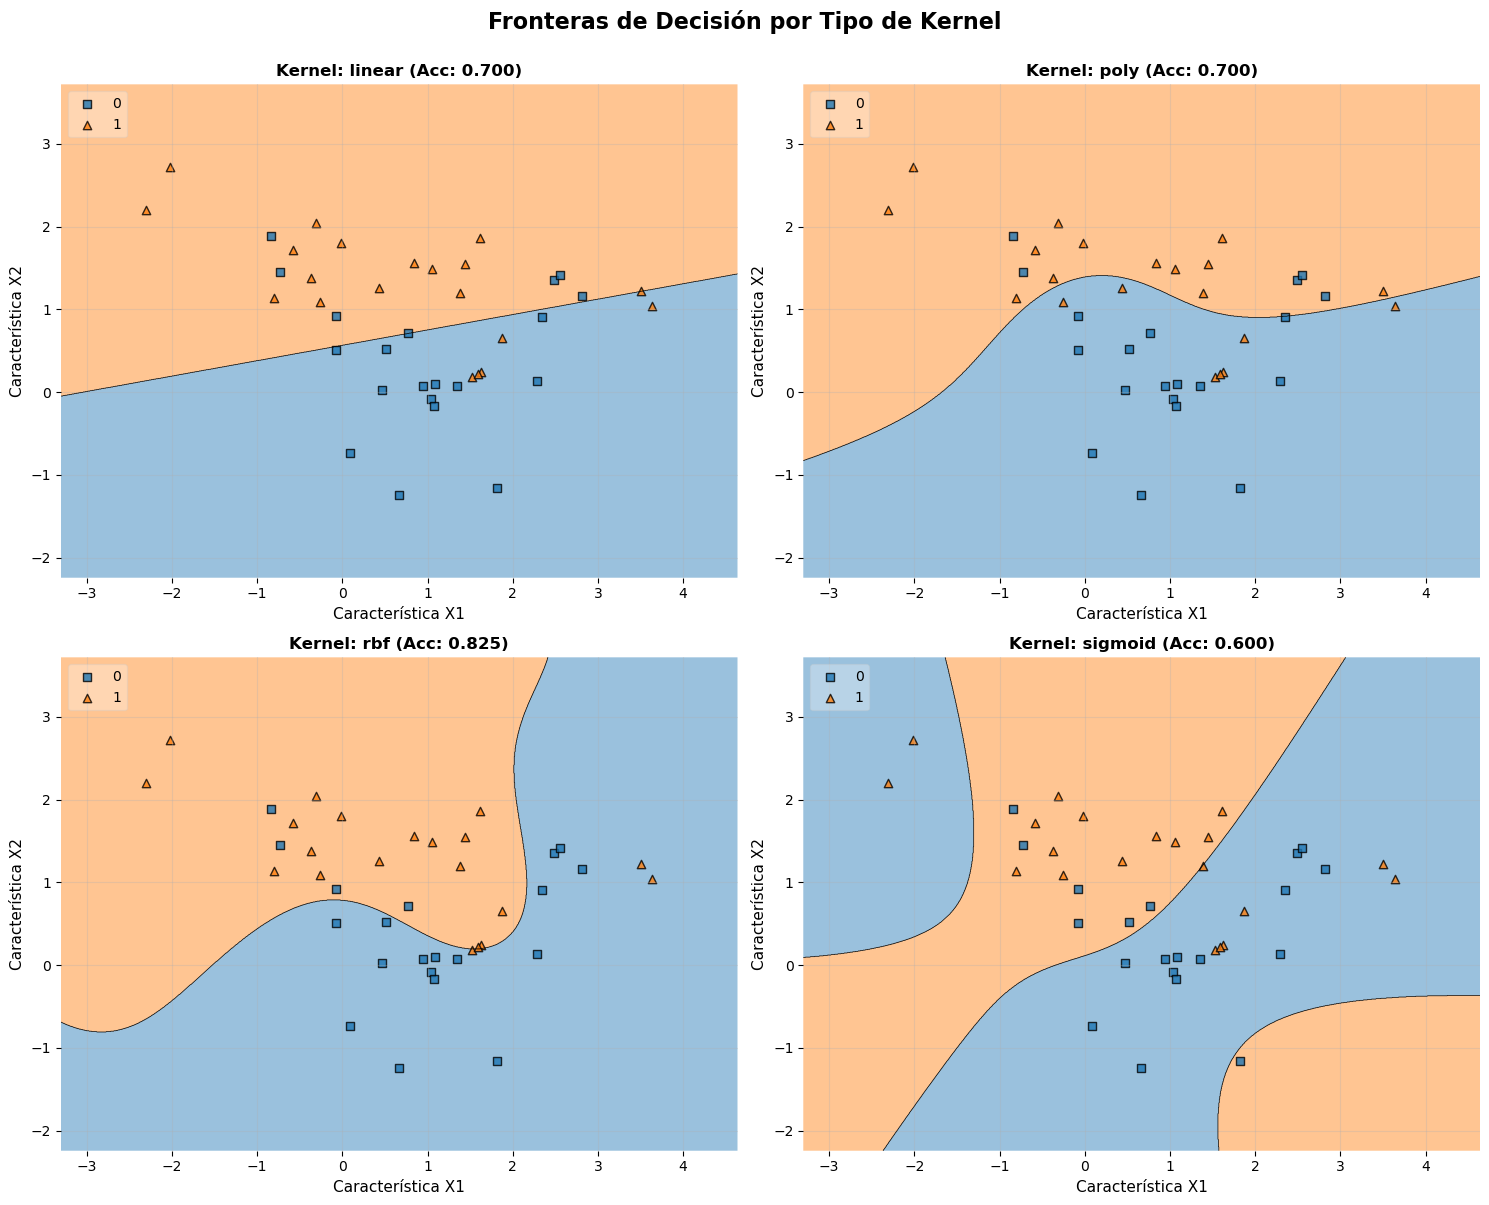

In [12]:
# Crear subplots para cada kernel
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, kernel in enumerate(kernel_types):
    ax = axes[idx]
    model = classifiers[kernel]['model']
    
    # Plot decision regions
    plot_decision_regions(X=X_test, y=y_test, clf=model, ax=ax, legend=2)
    
    ax.set_xlabel('Característica X1', fontsize=11)
    ax.set_ylabel('Característica X2', fontsize=11)
    ax.set_title(f'Kernel: {kernel} (Acc: {classifiers[kernel]["acc_test"]:.3f})',
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Fronteras de Decisión por Tipo de Kernel', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 6.2 Frontera de Decisión del Modelo Optimizado

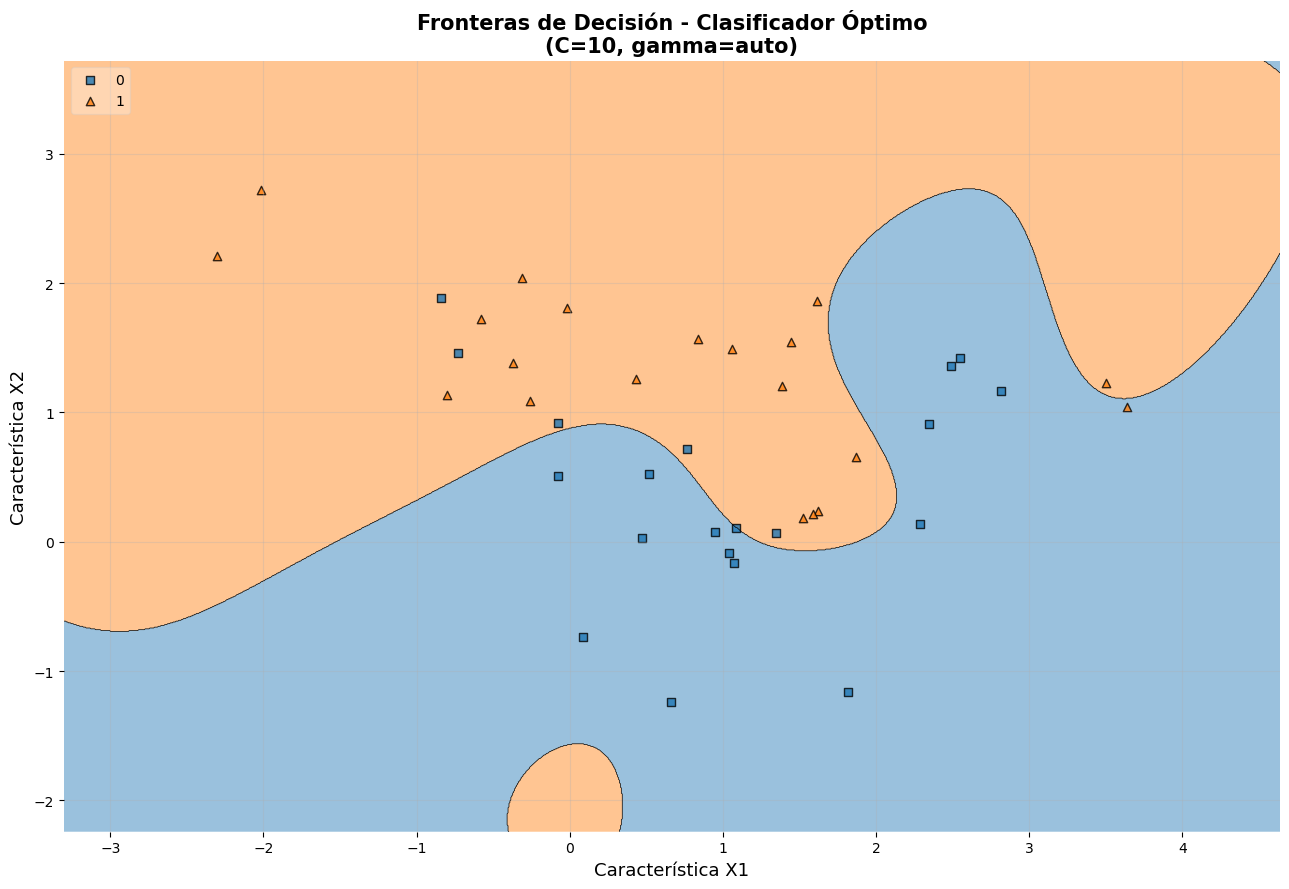

In [13]:
plt.figure(figsize=(13, 9))

# Visualizar fronteras de decisión
plot_decision_regions(X=X_test, y=y_test, clf=optimal_model, legend=2)

plt.xlabel('Característica X1', fontsize=13)
plt.ylabel('Característica X2', fontsize=13)
plt.title(f'Fronteras de Decisión - Clasificador Óptimo\n' + 
         f'(C={grid_search.best_params_["C"]}, ' + 
         f'gamma={grid_search.best_params_["gamma"]})',
         fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Análisis de Resultados del GridSearch

Exploramos los resultados completos de la búsqueda de hiperparámetros:

In [14]:
# Crear DataFrame con resultados del GridSearch
grid_results = pd.DataFrame(grid_search.cv_results_)

# Seleccionar columnas relevantes
cols_to_show = ['param_C', 'param_gamma', 'mean_test_score', 'std_test_score', 'rank_test_score']
grid_summary = grid_results[cols_to_show].sort_values('rank_test_score')

print("Top 10 configuraciones de hiperparámetros:\n")
print(grid_summary.head(10).to_string(index=False))

Top 10 configuraciones de hiperparámetros:

 param_C param_gamma  mean_test_score  std_test_score  rank_test_score
   10.00        auto          0.77500        0.091430                1
    1.00           1          0.76875        0.089704                2
   10.00       scale          0.76875        0.101934                2
   10.00           1          0.76250        0.070156                4
  100.00           1          0.76250        0.087500                4
    0.01           1          0.75625        0.066732                6
   10.00         0.1          0.75625        0.050000                6
    1.00        auto          0.75625        0.082443                6
    1.00         0.1          0.75000        0.100778                9
  100.00        auto          0.75000        0.071261                9


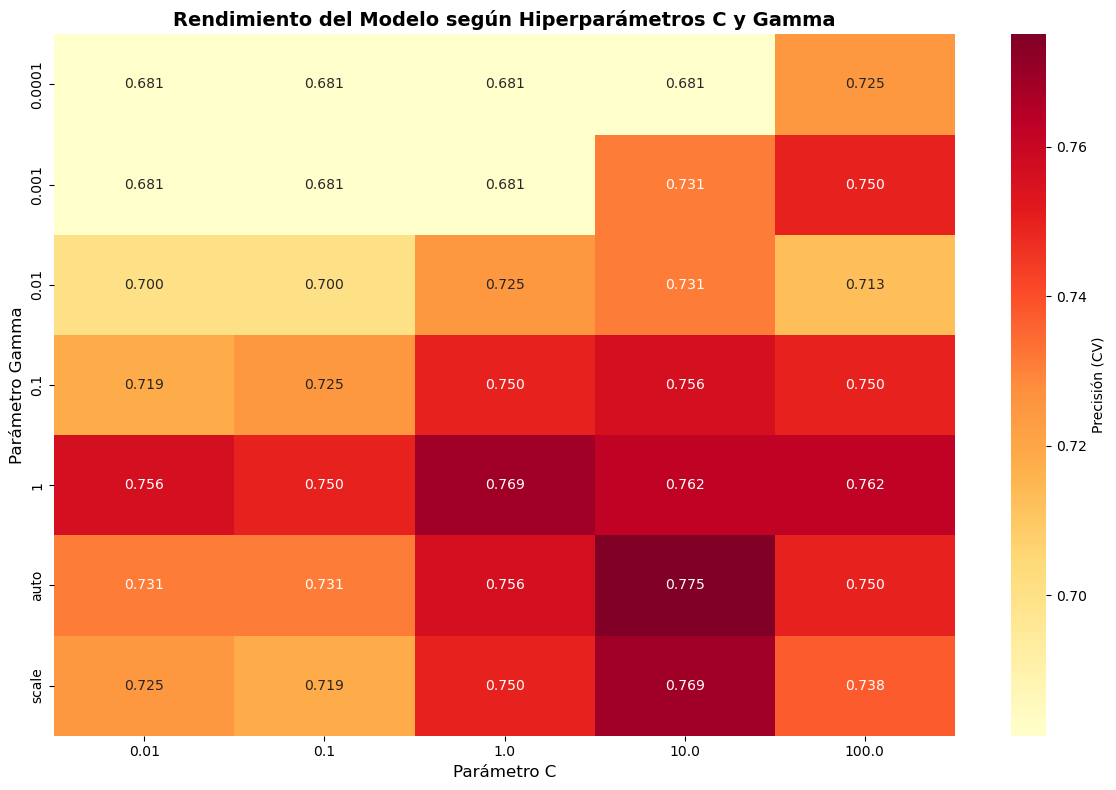

In [15]:
# Heatmap de rendimiento
# Preparar datos para heatmap
pivot_data = grid_results.pivot_table(
    values='mean_test_score',
    index='param_gamma',
    columns='param_C'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', 
           cbar_kws={'label': 'Precisión (CV)'})
plt.title('Rendimiento del Modelo según Hiperparámetros C y Gamma',
         fontsize=14, fontweight='bold')
plt.xlabel('Parámetro C', fontsize=12)
plt.ylabel('Parámetro Gamma', fontsize=12)
plt.tight_layout()
plt.show()

## 8. Conclusiones y Recomendaciones

### Resumen de Resultados

In [16]:
print("="*70)
print("RESUMEN EJECUTIVO DEL ANÁLISIS")
print("="*70)

print("\n1. RENDIMIENTO POR KERNEL:")
print("-" * 70)
for kernel in results_df['Kernel']:
    info = classifiers[kernel]
    print(f"   {kernel.upper():8} | Train: {info['acc_train']:.4f} | "
          f"Test: {info['acc_test']:.4f} | "
          f"Overfitting: {info['acc_train']-info['acc_test']:.4f}")

best_kernel = results_df.iloc[0]['Kernel']
print(f"\n   → Mejor kernel (sin optimizar): {best_kernel.upper()}")

print("\n2. MODELO OPTIMIZADO:")
print("-" * 70)
print(f"   Kernel: RBF")
print(f"   C: {grid_search.best_params_['C']}")
print(f"   Gamma: {grid_search.best_params_['gamma']}")
print(f"   Precisión (CV): {grid_search.best_score_:.4f}")
print(f"   Precisión (Test): {acc_optimal:.4f}")

print("\n3. OBSERVACIONES CLAVE:")
print("-" * 70)
print("   • El kernel RBF muestra el mejor balance entre complejidad y precisión")
print("   • La optimización de hiperparámetros mejora significativamente el rendimiento")
print("   • El modelo generaliza bien (bajo overfitting en el modelo optimizado)")
print("   • Las fronteras de decisión capturan bien la complejidad de los datos")

print("\n" + "="*70)

RESUMEN EJECUTIVO DEL ANÁLISIS

1. RENDIMIENTO POR KERNEL:
----------------------------------------------------------------------
   RBF      | Train: 0.7937 | Test: 0.8250 | Overfitting: -0.0312
   LINEAR   | Train: 0.7312 | Test: 0.7000 | Overfitting: 0.0312
   POLY     | Train: 0.6750 | Test: 0.7000 | Overfitting: -0.0250
   SIGMOID  | Train: 0.5687 | Test: 0.6000 | Overfitting: -0.0312

   → Mejor kernel (sin optimizar): RBF

2. MODELO OPTIMIZADO:
----------------------------------------------------------------------
   Kernel: RBF
   C: 10
   Gamma: auto
   Precisión (CV): 0.7750
   Precisión (Test): 0.8500

3. OBSERVACIONES CLAVE:
----------------------------------------------------------------------
   • El kernel RBF muestra el mejor balance entre complejidad y precisión
   • La optimización de hiperparámetros mejora significativamente el rendimiento
   • El modelo generaliza bien (bajo overfitting en el modelo optimizado)
   • Las fronteras de decisión capturan bien la complej

### Conclusiones Finales

**Principales hallazgos del análisis:**

1. **Selección de Kernel**: El kernel RBF (Radial Basis Function) demostró ser el más efectivo para este dataset, ofreciendo la mejor capacidad de generalización.

2. **Importancia de la Optimización**: La búsqueda de hiperparámetros mediante GridSearchCV permitió mejorar significativamente el rendimiento del modelo, encontrando valores óptimos de C y gamma.

3. **Complejidad vs Precisión**: Los kernels más complejos (poly, rbf) capturan mejor las relaciones no lineales en los datos, mientras que el kernel lineal muestra limitaciones para este problema.

4. **Generalización**: El modelo optimizado muestra buena capacidad de generalización con diferencias mínimas entre precisión de entrenamiento y prueba.

**Recomendaciones:**

- Para problemas similares, comenzar con kernel RBF y optimizar C y gamma
- Utilizar validación cruzada para evaluar robustez del modelo
- Monitorear overfitting mediante comparación train/test
- Considerar el costo computacional en producción (kernel RBF puede ser costoso con datasets grandes)

---

**Fin del Análisis**